In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/DINO

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/DINO


In [2]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-install-wdwq8nmq/pycocotools_516db3dceb1742f2b2a5bb4ed745533c
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-install-wdwq8nmq/pycocotools_516db3dceb1742f2b2a5bb4ed745533c
  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-install-wdwq8nmq/panopticapi_f14daba1eabd43de8a7cd5918e0ece6b
  Running command git clone -q https://github.com/cocodataset/panopticapi.git /tmp/pip-install-wdwq8nmq/panopticapi_f14daba1eabd43de8a7cd5918e0ece6b
     |████████████████████████████████| 73 kB 1.5 MB/s 
     |████████████████████████████████| 190 kB 10.5 MB/s 
     |████████████████████████████████| 549 kB 90.0 MB/s 
     |████████████████████████████████| 182 kB 86.3 MB/s 
  Created wheel for pycocotools: filename=pycocotools-2.0-cp38-cp38-linux_x86_64.whl size=304521 sha256=88a9f3d0c995d2e

In [3]:
%cd models/dino/ops
!python setup.py build install
%cd ../../..

/content/drive/MyDrive/DINO/models/dino/ops
running build
running build_py
running build_ext
/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py:476: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py:387: UserWarning: The detected CUDA version (11.2) has a minor version mismatch with the version that was used to compile PyTorch (11.6). Most likely this shouldn't be a problem.
  warnings.warn(CUDA_MISMATCH_WARN.format(cuda_str_version, torch.version.cuda))
running install
running bdist_egg
running egg_info
writing MultiScaleDeformableAttention.egg-info/PKG-INFO
writing dependency_links to MultiScaleDeformableAttention.egg-info/dependency_links.txt
writing top-level names to MultiScaleDeformableAttention.egg-info/top_level.txt
writing manifest file 'MultiS

# 0. Initialize and Load Pre-trained Models

In [ ]:
import os, sys
import torch, json
import numpy as np

from main import build_model_main
from util.slconfig import SLConfig
from datasets import build_dataset
from util.visualizer import COCOVisualizer
from util import box_ops

In [5]:
model_config_path = "config/DINO/DINO_4scale_2class.py" # change the path of the model config file
model_checkpoint_path = "checkpoint_best_regular_no_freeze.pth" # change the path of the model checkpoint
# See our Model Zoo section in README.md for more details about our pretrained models.

In [6]:
args = SLConfig.fromfile(model_config_path) 
args.device = 'cuda' 
model, criterion, postprocessors = build_model_main(args)
checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])
_ = model.eval()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [57]:
# load coco names
with open('util/coco_id2name.json') as f:
    id2name = json.load(f)
    id2name = {int(k):v for k,v in id2name.items()}

# 1. Train(fintuning, 4scale_resnet50)

In [3]:
!bash scripts/DINO_train_toreta.sh "/content/drive/MyDrive/DINO/toreta" "/content/drive/MyDrive/DINO/checkpoint0033_4scale.pth"

Not using distributed mode
Loading config file from config/DINO/DINO_4scale_2class.py
[12/29 02:15:37.344]: git:
  sha: 290cf6415166cc7cd0f68e5da973004e2f0e686b, status: has uncommited changes, branch: main

[12/29 02:15:37.345]: Command: main.py --output_dir logs/DINO/R50-MS4 -c config/DINO/DINO_4scale_2class.py --coco_path /content/drive/MyDrive/DINO/toreta --pretrain_model_path /content/drive/MyDrive/DINO/checkpoint0033_4scale.pth --finetune_ignore label_enc.weight class_embed --options dn_scalar=100 embed_init_tgt=TRUE dn_label_coef=1.0 dn_bbox_coef=1.0 use_ema=False dn_box_noise_scale=1.0
[12/29 02:15:37.348]: Full config saved to logs/DINO/R50-MS4/config_args_all.json
[12/29 02:15:37.349]: world size: 1
[12/29 02:15:37.349]: rank: 0
[12/29 02:15:37.349]: local_rank: 0
[12/29 02:15:37.349]: args: Namespace(add_channel_attention=False, add_pos_value=False, amp=False, aux_loss=True, backbone='resnet50', backbone_freeze_keywords=None, batch_norm_type='FrozenBatchNorm2d', batch_size=2

# 2. Visualize Custom Images

In [7]:
from PIL import Image, ImageDraw
import datasets.transforms as T

In [14]:
image = Image.open("./figs/toreta_ad_2.jpeg").convert("RGB") # load image

In [15]:
print(type(image))

<class 'PIL.Image.Image'>


In [16]:
# transform images
transform = T.Compose([
    T.RandomResize([800], max_size=1333),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
image, _ = transform(image, None)

In [17]:
image.shape

torch.Size([3, 902, 800])

In [18]:
# predict images
output = model.cuda()(image[None].cuda())
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([0.7435, 0.7359, 0.1828, 0.1764, 0.1738, 0.1428, 0.1386, 0.1353, 0.1352,
        0.1256, 0.1247, 0.1234, 0.1212, 0.1194, 0.1162, 0.1130, 0.1088, 0.1084,
        0.1055, 0.1029, 0.1025, 0.0996, 0.0966, 0.0934, 0.0914, 0.0889, 0.0869,
        0.0857, 0.0845, 0.0832, 0.0823, 0.0820, 0.0820, 0.0810, 0.0798, 0.0798,
        0.0784, 0.0782, 0.0780, 0.0773, 0.0772, 0.0763, 0.0760, 0.0755, 0.0747,
        0.0741, 0.0734, 0.0730, 0.0711, 0.0709, 0.0707, 0.0702, 0.0694, 0.0688,
        0.0679, 0.0677, 0.0670, 0.0663, 0.0661, 0.0639, 0.0635, 0.0635, 0.0626,
        0.0618, 0.0614, 0.0607, 0.0602, 0.0601, 0.0596, 0.0584, 0.0579, 0.0576,
        0.0573, 0.0571, 0.0570, 0.0566, 0.0564, 0.0563, 0.0563, 0.0562, 0.0559,
        0.0555, 0.0553, 0.0552, 0.0551, 0.0549, 0.0548, 0.0545, 0.0544, 0.0544,
        0.0542, 0.0537, 0.0535, 0.0525, 0.0524, 0.0523, 0.0522, 0.0517, 0.0517,
        0.0515, 0.0515, 0.0509, 0.0508, 0.0507, 0.0503, 0.0502, 0.0498, 0.0498,
        0.0496, 0.0495, 0.0493, 0.0492, 

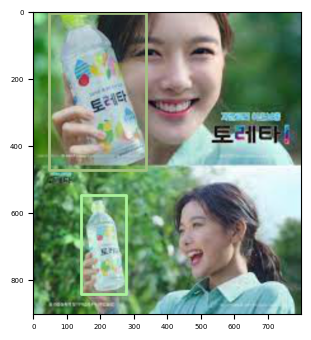

In [19]:
# visualize outputs
thershold = 0.29 # set a thershold

vslzr = COCOVisualizer()
scores = output['scores']
print(scores)
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold
# box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': torch.Tensor([image.shape[1], image.shape[2]]),
    # 'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None, dpi=100)

# 3. Visualize Video

In [8]:
import cv2
from torchvision.transforms.functional import to_pil_image

def draw_bbox(image, pred_dict, ratio):
  h_ratio, w_ratio = ratio
  boxes = pred_dict['boxes']
  size = pred_dict['size']
  image = Image.fromarray(image)
  draw = ImageDraw.Draw(image)
  for box in boxes:
    x1, y1, x2, y2 = box
    x1 = x1*size[1]*w_ratio
    y1 = y1*size[0]*h_ratio
    x2 = x2*size[1]*w_ratio
    y2 = y2*size[0]*h_ratio
    draw.rectangle((x1,y1,x2,y2), outline=(0,255,0), width=3)
  return np.array(image)

video_path = './figs/toreta_ad_1.mp4'
cap = cv2.VideoCapture(video_path)
transform = T.Compose([
    T.RandomResize([800], max_size=1333),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
w = round(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('toreta_dets.mp4', fourcc,fps, (w,h))

while (cap.isOpened()):
    ret, frame = cap.read()
    
    if ret:
        Image_frame = Image.fromarray(frame)
        tf_frame, _ = transform(Image_frame, None)
        ratio = (frame.shape[0]/tf_frame.shape[1], frame.shape[1]/tf_frame.shape[2])
        output = model.cuda()(tf_frame[None].cuda())
        output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]
        scores = output['scores']
        labels = output['labels']
        boxes = output['boxes']
        select_mask = scores > 0.3
        pred_dict = {
            'boxes': boxes[select_mask],
            'size': torch.Tensor([frame.shape[0], frame.shape[1]]),
        }
        frame = draw_bbox(frame, pred_dict, ratio)
        out.write(frame)
    else:
        break

cap.release()
out.release()
cv2.destroyAllWindows()

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
